In [1]:
import sys
sys.path.append('../../src')

In [2]:
import pandas
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.model.formulate import formulate, Constraints, Objective, ModelClass
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from itertools import product

from energiapy.components.result import Result
import pandas
from itertools import product
from matplotlib import rc
import matplotlib.pyplot as plt
from energiapy.model.solve import solve
from energiapy.plot.plot_results import CostY, CostX
from energiapy.components.location import Location
from energiapy.plot import plot_results, plot_scenario
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.model.bounds import CapacityBounds
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.components.transport import Transport
from energiapy.components.scenario import Scenario
from energiapy.components.network import Network
from energiapy.components.location import Location
from energiapy.components.material import Material

from energiapy.components.process import Process, VaryingProcess
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.temporal_scale import TemporalScale
import numpy
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.aggregation.reduce_scenario import reduce_scenario, Clustermethod
from energiapy.aggregation.ahc import agg_hierarchial_elbow, IncludeAHC, Fit
import matplotlib.pyplot as plt

from energiapy.model.weights import EmissionWeights


\begin{align}
\min_x \quad \theta^TH^Tx& + c^Tx\\
\text{s.t.} \quad Ax &\leq b + F\theta\\
A_{eq}x &= b_{eq}\\
A_\theta \theta &\leq b_\theta\\
x &\in R^n\\
\end{align}


In [3]:
scales = TemporalScale(discretization_list=[1])

In [4]:
bigM = 10**15
smallM = 0.0000000001

Declare Materials

In [5]:

LithiumCarbonateR = Material(name='LithiumCarbonateR', gwp=10602.89995, odp=0.0005311, acid=83.2005862, eutt=185.9710578, eutf=6.0273706, eutm=42.7091789, basis='kg CO2 eq./ton, kg CFC-11 eq./ton, kg SO2 eq./ton, mol N eq./ton, kg P eq./ton, kg N eq./ton', label='Rock-based Lithium',
                citation='https://www.iea.org/data-and-statistics/charts/ghg-emissions-intensity-for-lithium-by-resource-type-and-processing-route')  
LithiumCarbonateB = Material(name='LithiumCarbonateB', gwp=2147.78164, odp=0.0000323, acid=14.7111022, eutt=55.7722302, eutf=1.9709617, eutm=8.3834083, basis='kg CO2 eq./ton, kg CFC-11 eq./ton, kg SO2 eq./ton, mol N eq./ton, kg P eq./ton, kg N eq./ton', label='Brine-based Lithium',
               citation='https://www.iea.org/data-and-statistics/charts/ghg-emissions-intensity-for-lithium-by-resource-type-and-processing-route')  

Steel = Material(name ='steel', gwp= 2121.152427, odp=0.0000524, acid=7.071973, eutt=20.1478856, eutf=0.9654292, eutm=2.0671433, basis='kg CO2 eq./ton, kg CFC-11 eq./ton, kg SO2 eq./ton, mol N eq./ton, kg P eq./ton, kg N eq./ton', label = 'Steel', 
                 citation= 'Annika Eberle et al., (2023), Materials used in U.S. Wind Energy Technologies: Quanitities and Availability for Two Future Scenarios')

Cast_iron = Material(name ='cast iron', gwp= 1759.710573, odp=0.0000443, acid=6.0061499, eutt=18.2339132, eutf=0.66155, eutm=1.7330535, basis='kg CO2 eq./ton, kg CFC-11 eq./ton, kg SO2 eq./ton, mol N eq./ton, kg P eq./ton, kg N eq./ton', label = 'Cast iron', 
                 citation= 'Annika Eberle et al., (2023), Materials used in U.S. Wind Energy Technologies: Quanitities and Availability for Two Future Scenarios')

Concrete = Material(name ='concrete', gwp= 90.91, odp=0.00000040125, acid=0.246868, eutt=1.546130613, eutf=0.015425534, eutm=0.140321324, basis='kg CO2 eq./ton, kg CFC-11 eq./ton, kg SO2 eq./ton, mol N eq./ton, kg P eq./ton, kg N eq./ton', label = 'Concrete', 
                 citation= 'Annika Eberle et al., (2023), Materials used in U.S. Wind Energy Technologies: Quanitities and Availability for Two Future Scenarios')

Glass = Material(name = 'glass', gwp = 1118.5, odp=0.0000141, acid=8.8362743, eutt=22.0973602, eutf=0.1263297, eutm=1.8534905, basis='kg CO2 eq./ton, kg CFC-11 eq./ton, kg SO2 eq./ton, mol N eq./ton, kg P eq./ton, kg N eq./ton', label = 'glass',
                 citation = 'Statista.com/statistics/1118670/materials-used-manufacture-solar-pv-plant-globally. & https://solaredition.com/raw-materials-breakdown-for-building-a-1-megawatt-solar-photovoltaic-plant-2017')

Aluminium = Material(name = 'aluminium', gwp = 5632.53, odp=0.0000578, acid=31.2744756, eutt=65.5836037, eutf=1.8348121, eutm=6.2774955, basis='kg CO2 eq./ton, kg CFC-11 eq./ton, kg SO2 eq./ton, mol N eq./ton, kg P eq./ton, kg N eq./ton', label = 'aluminium',
                 citation = 'https://www.researchgate.net/figure/Overall-environmental-impact-per-kg-Pts-kg-and-GWP-kg-of-CO2-eq-kg-aluminium-of_fig2_295243557. & Statista.com/statistics/1118670/materials-used-manufacture-solar-pv-plant-globally. & https://solaredition.com/raw-materials-breakdown-for-building-a-1-megawatt-solar-photovoltaic-plant-2017')

Silicon = Material(name = 'silicon', gwp = 50137.8, odp=0.0012152, acid=188.0829961, eutt=469.8237153, eutf=18.9483911, eutm=46.3346166, basis='kg CO2 eq./ton, kg CFC-11 eq./ton, kg SO2 eq./ton, mol N eq./ton, kg P eq./ton, kg N eq./ton', label = 'silicon',
                 citation = 'Statista.com/statistics/1118670/materials-used-manufacture-solar-pv-plant-globally. & https://solaredition.com/raw-materials-breakdown-for-building-a-1-megawatt-solar-photovoltaic-plant-2017')

Copper = Material(name = 'copper', gwp = 8660.4, odp=0.0003416, acid=516.3936129, eutt=409.7976693, eutf=46.0940178, eutm=29.6096174, basis='kg CO2 eq./ton, kg CFC-11 eq./ton, kg SO2 eq./ton, mol N eq./ton, kg P eq./ton, kg N eq./ton', label = 'copper',
                 citation = 'Statista.com/statistics/1118670/materials-used-manufacture-solar-pv-plant-globally. & https://solaredition.com/raw-materials-breakdown-for-building-a-1-megawatt-solar-photovoltaic-plant-2017')


Declare Processes

In [6]:
Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', label='Power generated', demand = True, varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0,1))#(min(demand['COAST']), 1))

# H2O = Resource(name='H2O', cons_max=100, basis='tons', label='Water', varying= [VaryingResource.UNCERTAIN_AVAILABILITY], varying_bounds= (0.3, 0.95))
H2O = Resource(name='H2O', cons_max=500, basis='tons', label='Water')

O2 = Resource(name='O2', sell=True, basis='tons', label='Oxygen')

H2 = Resource(name='H2', basis='tons', label='Hydrogen', demand= True) #, varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0.6, 0.8))

Uranium = Resource(name='Uranium', cons_max=1000,
                   price=42.70/(250/2), basis='kg', label='Uranium')

LiI = Process(name='LiI', storage=Power, vopex=1302, capex=0, fopex=0,  prod_max=50,
              storage_loss=0.11,  label='Lithium-ion battery', basis='MW', store_max=100)

PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, H2O: -3.1839}, capex=0, fopex=0,
              vopex=1.55*10**3, prod_max=100, prod_min = 0, basis = 'tons', label = 'PEM' )


WF = Process(name='WF', conversion={Wind: -1, Power: 0.85}, vopex=990, capex=0, fopex=0,
             prod_max=100, label='Wind mill array', basis='MW', varying = [VaryingProcess.UNCERTAIN_CAPACITY])

PV = Process(name='PV', conversion={Solar: -1, Power: 0.75}, vopex=567, capex=0, fopex=0,
             prod_max=100, label='Solar PV', basis='MW', varying = [VaryingProcess.UNCERTAIN_CAPACITY])


ASMR = Process(name='ASMR', conversion={Uranium: -4.17*10**(-5), H2O: -3.364, Power: 1},
               capex=7988951, fopex=0.04*0.730, vopex=0, prod_max=50, label='Small modular reactors (SMRs)', block='power_gen')

# region = Location(name='region', processes={LiI, WF, PV}, scales=scales, label='some region wo dispatchable')

region = Location(name='region', processes={LiI, WF, PV, PEM}, scales=scales, label='some region')

scenario = Scenario(name='scenario', demand={region: {Power:80, H2: 35}}, network=region, scales=scales, label='example scenario')

matrix = formulate(scenario=scenario, model_class=ModelClass.MPLP)

The problem has the following variables:
Resource inventory level (Inv) x 1
Exact resource discharge (Sf) x 1
Uncertain resource discharge (S) x 1
Exact resource availability (Af) x 3
Uncertain resource availability (A) x 0
Exact resource price (Cf) x 3
Uncertain resource price (C) x 0
Exact process production (Pf) x 3
Uncertain process production (P) x 2
 For a total of 11 (8 fixed, and 3 uncertain)


In [7]:

# scales = TemporalScale(discretization_list=[1])

# Solar = Resource(name='Solar', cons_max=80, basis='MW', label='Solar Power')

# Wind = Resource(name='Wind', cons_max=85, basis='MW', label='Wind Power')

# Power = Resource(name='Power', basis='MW', label='Power generated', demand = True, varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0.5,1))#(min(demand['COAST']), 1))

# H2O = Resource(name='H2O', cons_max=500, basis='tons', label='Water')

# O2 = Resource(name='O2', sell=True, basis='tons', label='Oxygen')

# H2 = Resource(name='H2', basis='tons', label='Hydrogen', demand= True) #, varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0.6, 0.8))

# LiI = Process(name='LiI', storage=Power, vopex=1302, capex=0, fopex=0,  prod_max=20,
#             storage_loss=0.11,  label='Lithium-ion battery', basis='MW', store_max=30)

# WF = Process(name='WF', conversion={Wind: -1, Power: 0.85}, vopex=990, capex=0, fopex=0,
#             prod_max=95, label='Wind mill array', basis='MW', varying = [VaryingProcess.UNCERTAIN_CAPACITY]
#             , varying_bounds = (0.5,1))

# PV = Process(name='PV', conversion={Solar: -1, Power: 0.75}, vopex=567, capex=0, fopex=0,
#             prod_max=100, label='Solar PV', basis='MW', varying = [VaryingProcess.UNCERTAIN_CAPACITY]
#             , varying_bounds = (0.5,1))

# PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, H2O: -3.1839}, capex=1.55*10**6, fopex=0,
#               vopex=0, prod_max=100, prod_min = 0, basis = 'tons', label = 'PEM' )

# region = Location(name='region', processes={LiI, WF, PV, PEM}, scales=scales, label='some region wo dispatchable')
# scenario = Scenario(name='example', demand={region: {Power:100, H2:20}}, network=region, scales=scales, label='example scenario')
# matrix = formulate(scenario=scenario, model_class=ModelClass.MPLP)
#     # print(matrix)
#     # return matrix



In [8]:
# matrix['c'] = numpy.array([[   10],
#        [   0.],
#        [   0.],
#        [   0.],
#        [1302.],
#        [   0.],
#        [ 567.],
#        [ 990.]])

In [9]:
matrix['c'] = numpy.array([[   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [1302.],
       [1550.],
       [ 567.],
       [ 990.]])

In [10]:
solution= solve(matrix = matrix, interface = 'native', name = 'results', solver = 'ppopt') 

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-14
[]


In [11]:
len(solution.critical_regions)

1

In [12]:
solution.critical_regions[0]

Critical region with active set [0, 1, 2, 3, 4, 5, 7, 8, 15, 16, 23]
The Omega Constraint indices are [0, 1, 2, 3, 4, 5]
The Lagrange multipliers Constraint indices are []
The Regular Constraint indices are [[2, 3, 5, 7, 9, 11, 12, 13, 15, 16], [10, 11, 13, 17, 19, 21, 22, 24, 26, 27]]
  x(θ) = Aθ + b 
 λ(θ) = Cθ + d 
  Eθ <= f
 A = [[ 8.98876404e+01 -8.42696629e+01 -9.55056180e+01]
 [-2.40238296e-14  1.31077598e-14  1.35982768e-14]
 [ 8.00000000e+01  4.13476012e-14  2.53949504e-14]
 [-3.40016438e-13  4.61812506e-13  4.27647045e-13]
 [-1.17111356e-15  1.00000000e+02 -1.21496438e-15]
 [ 5.15521906e-14  1.58441604e-14  1.00000000e+02]
 [-1.91317835e-15  4.11973935e-17 -1.72708009e-14]
 [ 8.98876404e+01 -8.42696629e+01 -9.55056180e+01]
 [-9.07126842e-14  1.54732136e-13  1.36103163e-13]
 [ 2.00229209e-14  1.00000000e+02  3.42930573e-14]
 [-2.22044605e-15 -1.77933581e-14  1.00000000e+02]] 
 b = [[ 1.11184175e+02]
 [ 3.50000000e+01]
 [-5.13226456e-14]
 [ 3.15059372e+02]
 [ 8.18276758e-15]
 [

In [13]:
solution.evaluate(numpy.array([[0.8], [0.9], [0.9]]))

array([[2.12965345e+01],
       [3.50000000e+01],
       [6.40000000e+01],
       [3.15059372e+02],
       [9.00000000e+01],
       [9.00000000e+01],
       [5.01820286e-14],
       [2.12965345e+01],
       [9.89539157e+01],
       [9.00000000e+01],
       [9.00000000e+01]])

In [14]:
solution.evaluate_objective(numpy.array([[0.9], [0.9], [0.9]]))

array([[332940.02817725]])

In [15]:
scenario.c_df

,0
Inv_LiI_Power_stored,0.0
Sf_H2,0.0
S_Power,0.0
Af_H2O,0.0
Af_Solar,0.0
Af_Wind,0.0
Pf_LiI,1302.0
Pf_LiI_discharge,0.0
Pf_PEM,1550.0
P_PV,567.0


## Changes to OG problem to add MOO (emission objectives)

In [16]:
matrix['F'] = numpy.array([numpy.concatenate((i, numpy.array([0]*6)), axis = 0) for i in matrix['F']])

In [17]:
matrix['CRa'] = numpy.concatenate((numpy.eye(9),-numpy.eye(9)))

In [18]:
matrix['CRb'] = numpy.concatenate((numpy.array([[1] for i in range(9)]), numpy.array([[0] for i in range(9)])))

In [19]:
# add sum of thetas = 1
# matrix['A'] = numpy.vstack((matrix['A'], numpy.array([0]*8)))
# matrix['F'] = numpy.vstack((matrix['F'], numpy.concatenate((numpy.array([0]*3), numpy.array([-1]*6)), axis = 0)))
# matrix['b'] = numpy.vstack((matrix['b'], numpy.array([1])))

In [20]:
material_cons_LiI = {LithiumCarbonateR: 20}
material_cons_WF = {Steel: 109.9, Cast_iron: 8.805, Concrete: 398.7}
material_cons_PV = {Glass: 70, Steel: 56, Concrete: 48, Aluminium: 19, Silicon: 7, Copper: 7}
material_cons_dict = {'PV': material_cons_PV, 'WF': material_cons_WF, 'LiI': material_cons_LiI}
material_cons_dict2 = {i: {m.name: n for m,n in j.items()} for i,j in material_cons_dict.items()}
objective_dict = {i: {m.name: {a: b*material_cons_dict2[i][m.name] for a,b in m.emission_potentials_dict.items()} for m,n in j.items()} for i, j in material_cons_dict.items()}


In [30]:
objective_dict

{'PV': {'gwp': 720048.685912,
  'odp': 0.015936460000000003,
  'acid': 6551.9706524,
  'eutt': 10152.749239524,
  'eutf': 553.805832032,
  'eutm': 903.121835852},
 'WF': {'gwp': 284854.720322565,
  'odp': 0.006308799875,
  'acid': 928.5202541694999,
  'eutt': 2991.2445085690997,
  'eutf': 118.07577723579999,
  'eutm': 298.3846966163},
 'LiI': {'gwp': 212057.999,
  'odp': 0.010622,
  'acid': 1664.011724,
  'eutt': 3719.4211560000003,
  'eutf': 120.54741200000001,
  'eutm': 854.1835779999999}}

In [21]:

def calculate_total_potentials(data):
    totals = {}
    for process, materials in data.items():
        totals[process] = {}
        for material, impacts in materials.items():
            for impact, value in impacts.items():
                if impact not in totals[process]:
                    totals[process][impact] = 0
                totals[process][impact] += value
    return totals
objective_dict = calculate_total_potentials(objective_dict)



In [22]:

# Calculate and print total potentials
LiI_obj = numpy.array([[objective_dict['LiI'][i]] for i in ['gwp', 'odp', 'acid', 'eutt', 'eutf', 'eutm'] ])
LiI_d_obj = numpy.array([[0] for i in ['gwp', 'odp', 'acid', 'eutt', 'eutf', 'eutm'] ])
PEM_obj = numpy.array([[0] for i in ['gwp', 'odp', 'acid', 'eutt', 'eutf', 'eutm'] ])
PV_obj = numpy.array([[objective_dict['PV'][i]] for i in ['gwp', 'odp', 'acid', 'eutt', 'eutf', 'eutm'] ])
WF_obj = numpy.array([[objective_dict['WF'][i]] for i in ['gwp', 'odp', 'acid', 'eutt', 'eutf', 'eutm'] ])




In [23]:
H2 = numpy.concatenate((numpy.zeros((6,6)), numpy.concatenate((LiI_obj, LiI_d_obj, PEM_obj, PV_obj, WF_obj), axis = 1)), axis = 1)
H1 = numpy.zeros((3,11))
matrix['H'] = numpy.concatenate((H1, H2)).transpose()

In [24]:
# material_cons_LiI = {LithiumCarbonateR: 20}
# material_cons_WF = {Steel: 109.9, Cast_iron: 8.805, Concrete: 398.7}
# material_cons_PV = {Glass: 70, Steel: 56, Concrete: 48, Aluminium: 19, Silicon: 7, Copper: 7}
# material_cons_dict = {'PV': material_cons_PV, 'WF': material_cons_WF, 'LiI': material_cons_LiI}
# material_cons_dict2 = {i: {m.name: n for m,n in j.items()} for i,j in material_cons_dict.items()}
# objective_dict = {i: {m.name: {a: b*material_cons_dict2[i][m.name] for a,b in m.emission_potentials_dict.items()} for m,n in j.items()} for i, j in material_cons_dict.items()}
# def calculate_total_potentials(data):
#     totals = {}
#     for process, materials in data.items():
#         totals[process] = {}
#         for material, impacts in materials.items():
#             for impact, value in impacts.items():
#                 if impact not in totals[process]:
#                     totals[process][impact] = 0
#                 totals[process][impact] += value
#     return totals

# # Calculate and print total potentials
# objective_dict = calculate_total_potentials(objective_dict)
# H1 = numpy.zeros((3,8))
# LiI_obj = numpy.array([[objective_dict['LiI'][i]] for i in ['gwp', 'odp', 'acid', 'eutt', 'eutf', 'eutm'] ])
# LiI_d_obj = numpy.array([[0] for i in ['gwp', 'odp', 'acid', 'eutt', 'eutf', 'eutm'] ])
# PV_obj = numpy.array([[objective_dict['PV'][i]] for i in ['gwp', 'odp', 'acid', 'eutt', 'eutf', 'eutm'] ])
# WF_obj = numpy.array([[objective_dict['WF'][i]] for i in ['gwp', 'odp', 'acid', 'eutt', 'eutf', 'eutm'] ])
# H2 = numpy.concatenate((numpy.zeros((6,4)), numpy.concatenate((LiI_obj, LiI_d_obj, PV_obj, WF_obj), axis = 1)), axis = 1)
# matrix['H'] = numpy.concatenate((H1, H2)).transpose()

In [25]:
# matrix['c'] = numpy.array([[0] for _ in range(11)])

In [26]:
solution_moo = solve(matrix = matrix, interface = 'native', name = 'results', solver = 'ppopt') 

[]


In [27]:
len(solution_moo.critical_regions)

5

\begin{align}
x(\theta) &= A\theta + b\\
\lambda(\theta) &= C\theta + d\\
\Theta &:= \{\forall \theta \in \mathbf{R}^m: E\theta \leq f\}
\end{align}

In [40]:
x_1 = numpy.linspace(0.0001,0.9999, 50)
plt_ = []
for index, _ in enumerate(x_1):
    x_sol = solution_moo.evaluate_objective(numpy.array([[0.3], [0.9], [0.9], [x_1[index]], [0.001], [0.001], [0.001], [0.001], [0.001]]))
    if x_sol is not None:
        plt_.append(x_sol[0][0])
    else:
        plt_.append(x_sol)

0.0001 0.9999 [90441306.56111094] [2.00207339]
[[3.31900646e+00]
 [3.50000000e+01]
 [4.80000000e+01]
 [3.15059372e+02]
 [9.00000000e+01]
 [9.00000000e+01]
 [5.05646643e-14]
 [3.31900646e+00]
 [9.89539157e+01]
 [9.00000000e+01]
 [9.00000000e+01]]
0.001100800800800801 0.9988991991991992 [50554368.73367166] [1.11927671]
[[5.00000000e+01]
 [3.50000000e+01]
 [4.80000000e+01]
 [3.15059372e+02]
 [3.46052210e+01]
 [9.00000000e+01]
 [6.94650305e-14]
 [5.00000000e+01]
 [9.89539157e+01]
 [3.46052210e+01]
 [9.00000000e+01]]
0.0021016016016016017 0.9978983983983984 [50554368.73367166] [1.11927671]
[[5.00000000e+01]
 [3.50000000e+01]
 [4.80000000e+01]
 [3.15059372e+02]
 [3.46052210e+01]
 [9.00000000e+01]
 [6.94650305e-14]
 [5.00000000e+01]
 [9.89539157e+01]
 [3.46052210e+01]
 [9.00000000e+01]]
0.0031024024024024024 0.9968975975975976 [50554368.73367166] [1.11927671]
[[5.00000000e+01]
 [3.50000000e+01]
 [4.80000000e+01]
 [3.15059372e+02]
 [3.46052210e+01]
 [9.00000000e+01]
 [6.94650305e-14]
 [5.00000

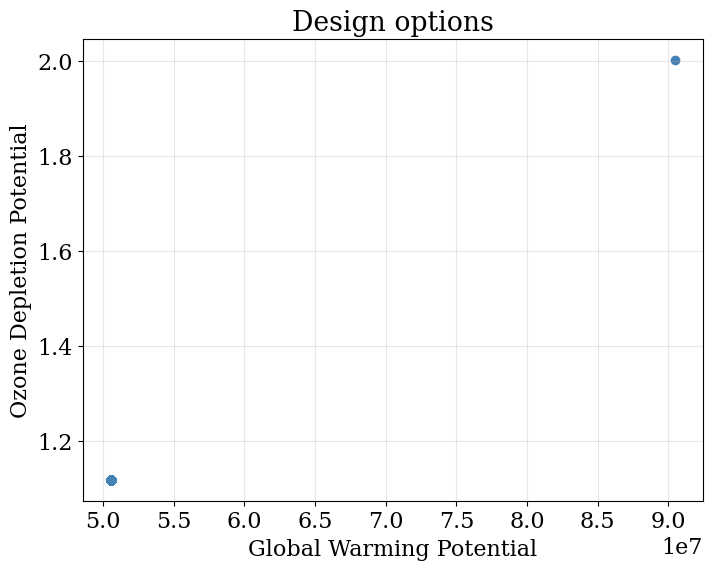

In [157]:
import random
from energiapy.utils.math_utils import normalize

# gwp vs odp
number  = 1000
x_1 = numpy.linspace(0.0001,0.9999, number)
x_2 = 1 - x_1 
obj1, obj2 = [], []


# random_demand = [random.random() for _ in range(number)]
# random_PV = [random.random() for _ in range(number)]
# random_WF = [random.random() for _ in range(number)]


for index, _ in enumerate(x_1):
    x_sol = solution_moo.evaluate(numpy.array([[0.6], [0.9], [0.9], [x_1[index]], [x_2[index]], [0.001], [0.001], [0.001], [0.001]]))
    # print(x_sol)
    if x_sol is not None:
        obj_1 = matrix['H'].T[3]@x_sol 
        obj_2 = matrix['H'].T[4]@x_sol
        obj1.append(obj_1[0])
        obj2.append(obj_2[0])
        # print([random_demand[index]], [random_PV[index]], [random_WF[index]])
        print(x_1[index], x_2[index], obj_1, obj_2)
        print(x_sol)
        
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=False)
fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(normalize(obj1), normalize(obj2), color='steelblue')
ax.scatter(obj1, obj2, color='steelblue')

# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
plt.title(f'Design options')
plt.ylabel("Ozone Depletion Potential")
plt.xlabel("Global Warming Potential")
plt.grid(alpha=0.3)
plt.rcdefaults()

In [165]:
c = solution_moo.program.c

In [173]:
x1 = numpy.array([[5.00000000e+01],
 [3.50000000e+01],
 [4.80000000e+01],
 [3.15059372e+02],
 [3.46052210e+01],
 [9.00000000e+01],
 [6.94650305e-14],
 [5.00000000e+01],
 [9.89539157e+01],
 [3.46052210e+01],
 [9.00000000e+01]])

x2 = numpy.array([[3.31900646e+00],
 [3.50000000e+01],
 [4.80000000e+01],
 [3.15059372e+02],
 [9.00000000e+01],
 [9.00000000e+01],
 [5.05646643e-14],
 [3.31900646e+00],
 [9.89539157e+01],
 [9.00000000e+01],
 [9.00000000e+01]])

In [172]:
c.T@x1

array([[327199.729642]])

In [174]:
c.T@x2

array([[297829.91574592]])

0.0001 0.9999 [620550.13693287] [58107.35341241]
[[5.00000000e+01]
 [3.50000000e+01]
 [4.80000000e+01]
 [3.15059372e+02]
 [3.46052210e+01]
 [9.00000000e+01]
 [6.94650305e-14]
 [5.00000000e+01]
 [9.89539157e+01]
 [3.46052210e+01]
 [9.00000000e+01]]
0.001100800800800801 0.9988991991991992 [620550.13693287] [58107.35341241]
[[5.00000000e+01]
 [3.50000000e+01]
 [4.80000000e+01]
 [3.15059372e+02]
 [3.46052210e+01]
 [9.00000000e+01]
 [6.94650305e-14]
 [5.00000000e+01]
 [9.89539157e+01]
 [3.46052210e+01]
 [9.00000000e+01]]
0.0021016016016016017 0.9978983983983984 [620550.13693287] [58107.35341241]
[[5.00000000e+01]
 [3.50000000e+01]
 [4.80000000e+01]
 [3.15059372e+02]
 [3.46052210e+01]
 [9.00000000e+01]
 [6.94650305e-14]
 [5.00000000e+01]
 [9.89539157e+01]
 [3.46052210e+01]
 [9.00000000e+01]]
0.0031024024024024024 0.9968975975975976 [620550.13693287] [58107.35341241]
[[5.00000000e+01]
 [3.50000000e+01]
 [4.80000000e+01]
 [3.15059372e+02]
 [3.46052210e+01]
 [9.00000000e+01]
 [6.94650305e-14]
 

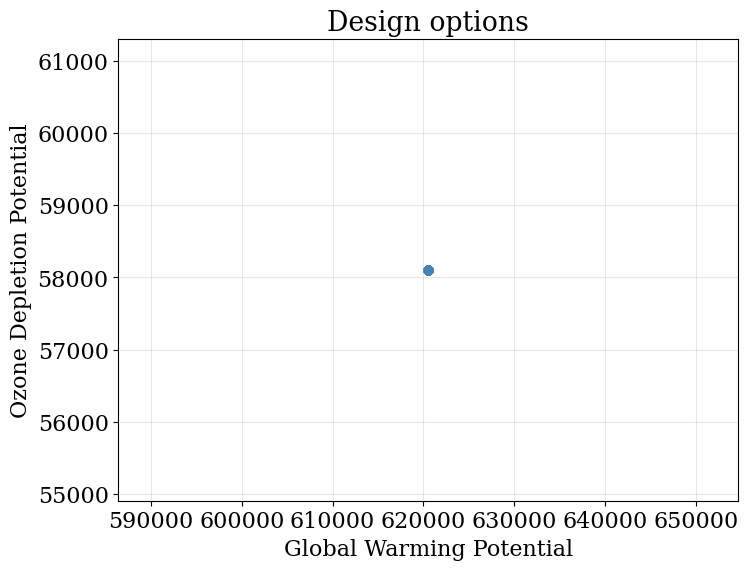

In [161]:
import random
from energiapy.utils.math_utils import normalize

# gwp vs odp
number  = 1000
x_1 = numpy.linspace(0.0001,0.9999, number)
x_2 = 1 - x_1 
obj1, obj2 = [], []


# random_demand = [random.random() for _ in range(number)]
# random_PV = [random.random() for _ in range(number)]
# random_WF = [random.random() for _ in range(number)]


for index, _ in enumerate(x_1):
    x_sol = solution_moo.evaluate(numpy.array([[0.6], [0.9], [0.9], [0.001], [0.001], [0.001], [x_1[index]], [0.001], [x_2[index]]]))
    # print(x_sol)
    if x_sol is not None:
        obj_1 = matrix['H'].T[6]@x_sol 
        obj_2 = matrix['H'].T[8]@x_sol
        obj1.append(obj_1[0])
        obj2.append(obj_2[0])
        # print([random_demand[index]], [random_PV[index]], [random_WF[index]])
        print(x_1[index], x_2[index], obj_1, obj_2)
        print(x_sol)
        
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=False)
fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(normalize(obj1), normalize(obj2), color='steelblue')
ax.scatter(obj1, obj2, color='steelblue')

# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
plt.title(f'Design options')
plt.ylabel("Ozone Depletion Potential")
plt.xlabel("Global Warming Potential")
plt.grid(alpha=0.3)
plt.rcdefaults()

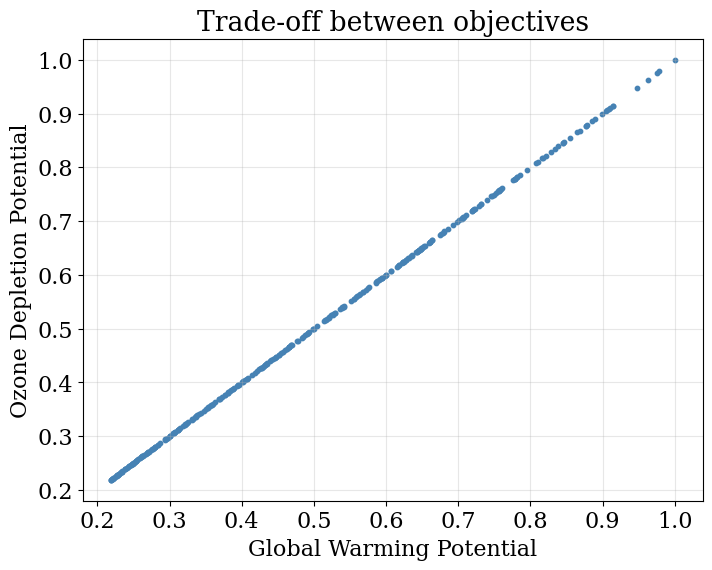

In [91]:
import random
from energiapy.utils.math_utils import normalize

# gwp vs odp
number  = 1000
x_1 = numpy.linspace(0.0001,0.9999, number)
x_2 = 1 - x_1 
obj1, obj2 = [], []


random_demand = [random.random() for _ in range(number)]
random_PV = [random.random() for _ in range(number)]
random_WF = [random.random() for _ in range(number)]


for index, _ in enumerate(x_1):
    x_sol = solution_moo.evaluate(numpy.array([[random_demand[index]], [random_PV[index]], [random_WF[index]], [x_1[index]], [x_2[index]], [0.001], [0.001], [0.001], [0.001]]))
    # print(x_sol)
    if x_sol is not None:
        obj_1 = matrix['H'].T[3]@x_sol 
        obj_2 = matrix['H'].T[4]@x_sol
        obj1.append(obj_1[0])
        obj2.append(obj_2[0])
        # print([random_demand[index]], [random_PV[index]], [random_WF[index]])
        # print(x_1[index], x_2[index], obj_1, obj_2)
        # print(x_sol)
        
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(normalize(obj1), normalize(obj2), s=10, color='steelblue')
# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
plt.title(f'Trade-off between objectives')
plt.ylabel("Ozone Depletion Potential")
plt.xlabel("Global Warming Potential")
plt.grid(alpha=0.3)
plt.rcdefaults()

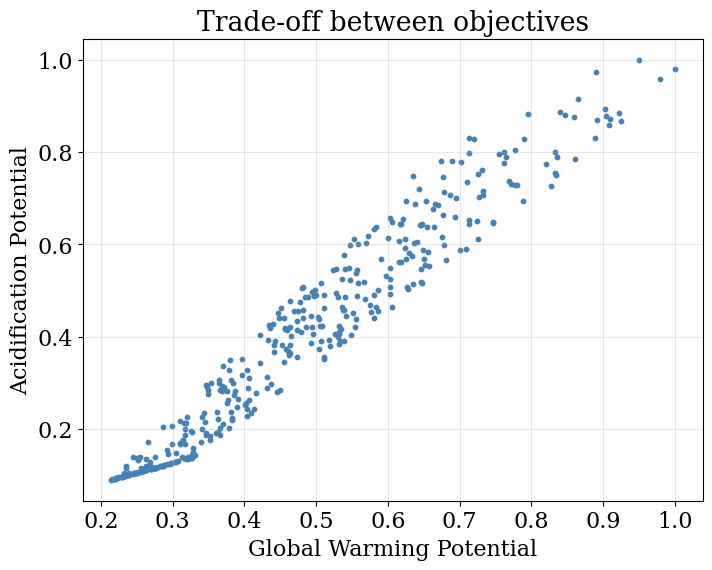

In [92]:
import random
from energiapy.utils.math_utils import normalize

# gwp vs odp
number  = 1000
x_1 = numpy.linspace(0.0001,0.9999, number)
x_2 = 1 - x_1 
obj3, obj4 = [], []


random_demand = [random.random() for _ in range(number)]
random_PV = [random.random() for _ in range(number)]
random_WF = [random.random() for _ in range(number)]


for index, _ in enumerate(x_1):
    x_sol = solution_moo.evaluate(numpy.array([[random_demand[index]], [random_PV[index]], [random_WF[index]], [x_1[index]], [0.001], [x_2[index]], [0.001], [0.001], [0.001]]))
    # print(x_sol)
    if x_sol is not None:
        obj_1 = matrix['H'].T[3]@x_sol 
        obj_2 = matrix['H'].T[5]@x_sol
        obj3.append(obj_1[0])
        obj4.append(obj_2[0])
        # print([random_demand[index]], [random_PV[index]], [random_WF[index]])
        # print(x_1[index], x_2[index], obj_1, obj_2)
        # print(x_sol)
        
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(normalize(obj3), normalize(obj4), s=10, color='steelblue')
# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
plt.title(f'Trade-off between objectives')
plt.ylabel("Acidification Potential")
plt.xlabel("Global Warming Potential")
plt.grid(alpha=0.3)
plt.rcdefaults()

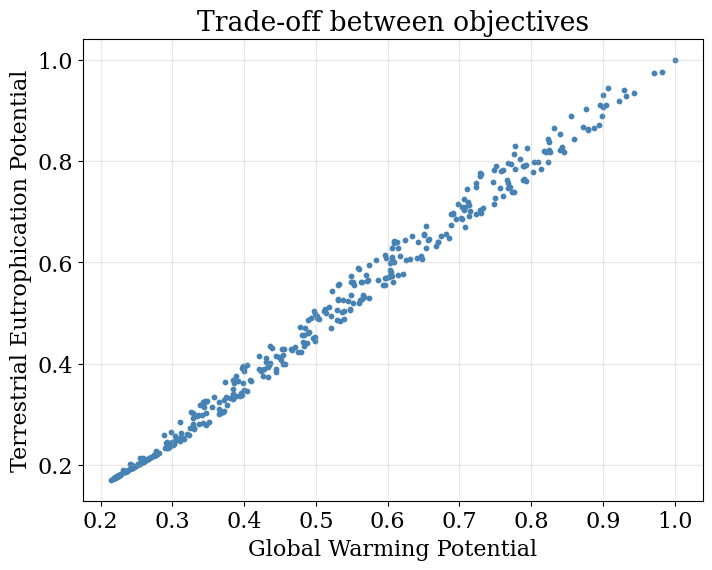

In [93]:
import random
from energiapy.utils.math_utils import normalize

# gwp vs odp
number  = 1000
x_1 = numpy.linspace(0.0001,0.9999, number)
x_2 = 1 - x_1 
obj5, obj6 = [], []


random_demand = [random.random() for _ in range(number)]
random_PV = [random.random() for _ in range(number)]
random_WF = [random.random() for _ in range(number)]


for index, _ in enumerate(x_1):
    x_sol = solution_moo.evaluate(numpy.array([[random_demand[index]], [random_PV[index]], [random_WF[index]], [x_1[index]], [0.001], [0.001], [x_2[index]], [0.001], [0.001]]))
    # print(x_sol)
    if x_sol is not None:
        obj_1 = matrix['H'].T[3]@x_sol 
        obj_2 = matrix['H'].T[6]@x_sol
        obj5.append(obj_1[0])
        obj6.append(obj_2[0])
        # print([random_demand[index]], [random_PV[index]], [random_WF[index]])
        # print(x_1[index], x_2[index], obj_1, obj_2)
        # print(x_sol)
        
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(normalize(obj5), normalize(obj6), s=10, color='steelblue')
# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
plt.title(f'Trade-off between objectives')
plt.ylabel("Terrestrial Eutrophication Potential")
plt.xlabel("Global Warming Potential")
plt.grid(alpha=0.3)
plt.rcdefaults()

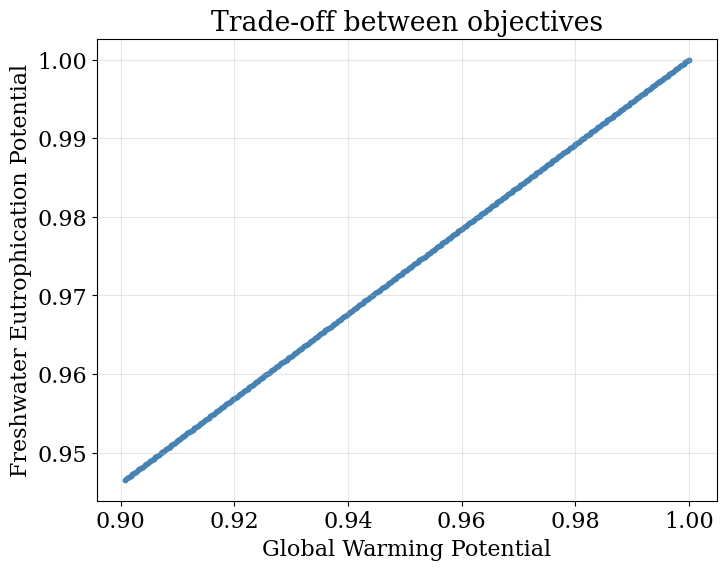

In [175]:
import random
from energiapy.utils.math_utils import normalize

# gwp vs odp
number  = 1000
x_1 = numpy.linspace(0.0001,0.9999, number)
x_2 = 1 - x_1 
obj7, obj8 = [], []


# random_demand = [random.random() for _ in range(number)]
# random_PV = [random.random() for _ in range(number)]
# random_WF = [random.random() for _ in range(number)]


random_demand = numpy.linspace(0.0001,0.9999, number)
random_PV = numpy.linspace(0.0001,0.9999, number)
random_WF = numpy.linspace(0.0001,0.9999, number)


for index, _ in enumerate(x_1):
    x_sol = solution_moo.evaluate(numpy.array([[random_demand[index]], [random_PV[index]], [random_WF[index]], [x_1[index]], [0.001], [0.001], [0.001], [x_2[index]], [0.001]]))
    # print(x_sol)
    if x_sol is not None:
        obj_1 = matrix['H'].T[3]@x_sol 
        obj_2 = matrix['H'].T[7]@x_sol
        obj7.append(obj_1[0])
        obj8.append(obj_2[0])
        # print([random_demand[index]], [random_PV[index]], [random_WF[index]])
        # print(x_1[index], x_2[index], obj_1, obj_2)
        # print(x_sol)
        
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(normalize(obj7), normalize(obj8), s=10, color='steelblue')
# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
plt.title(f'Trade-off between objectives')
plt.ylabel("Freshwater Eutrophication Potential")
plt.xlabel("Global Warming Potential")
plt.grid(alpha=0.3)
plt.rcdefaults()

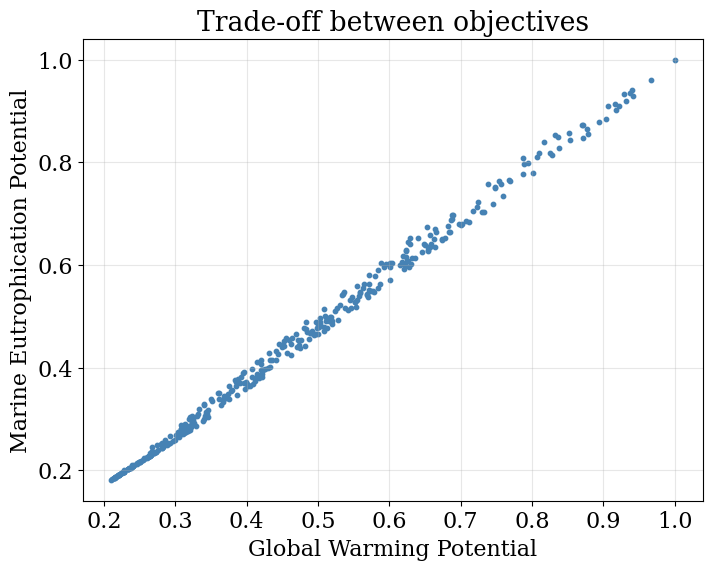

In [95]:
import random
from energiapy.utils.math_utils import normalize

# gwp vs odp
number  = 1000
x_1 = numpy.linspace(0.0001,0.9999, number)
x_2 = 1 - x_1 
obj9, obj10 = [], []


random_demand = [random.random() for _ in range(number)]
random_PV = [random.random() for _ in range(number)]
random_WF = [random.random() for _ in range(number)]


for index, _ in enumerate(x_1):
    x_sol = solution_moo.evaluate(numpy.array([[random_demand[index]], [random_PV[index]], [random_WF[index]], [x_1[index]], [0.001], [0.001], [0.001], [0.001], [x_2[index]]]))
    # print(x_sol)
    if x_sol is not None:
        obj_1 = matrix['H'].T[3]@x_sol 
        obj_2 = matrix['H'].T[8]@x_sol
        obj9.append(obj_1[0])
        obj10.append(obj_2[0])
        # print([random_demand[index]], [random_PV[index]], [random_WF[index]])
        # print(x_1[index], x_2[index], obj_1, obj_2)
        # print(x_sol)
        
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(normalize(obj9), normalize(obj10), s=10, color='steelblue')
# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
plt.title(f'Trade-off between objectives')
plt.ylabel("Marine Eutrophication Potential")
plt.xlabel("Global Warming Potential")
plt.grid(alpha=0.3)
plt.rcdefaults()

In [100]:
ax

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

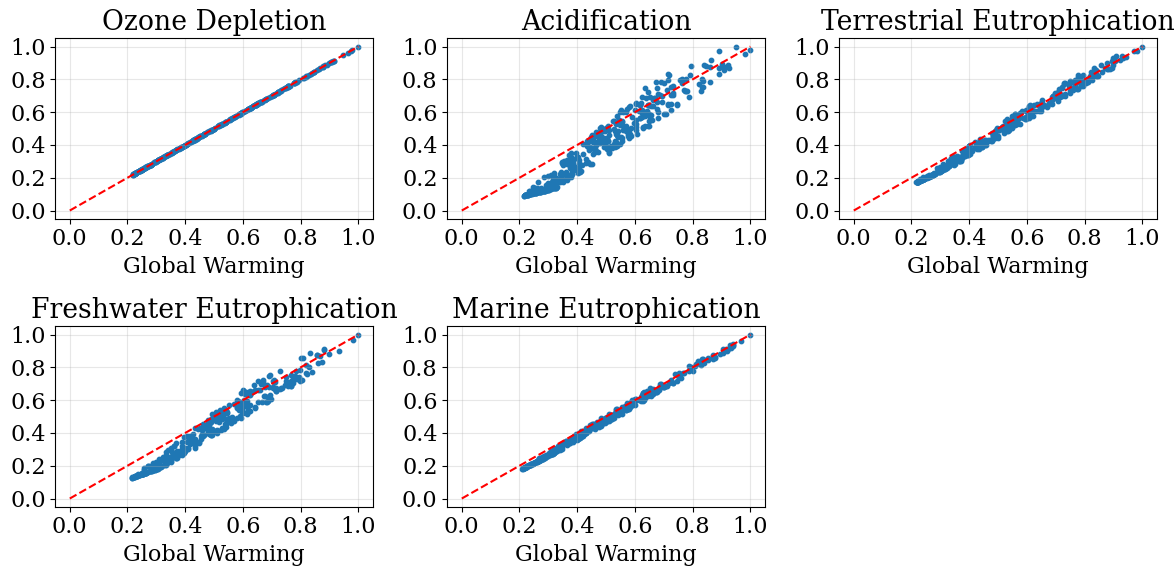

In [151]:
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=False)
fig, ax = plt.subplots(2,3, figsize=(12,6))
ax = ax.flatten()
ax[0].scatter(normalize(obj1), normalize(obj2), s=10, label = 'Ozone Depletion')
ax[1].scatter(normalize(obj3), normalize(obj4), s=10, label = 'Acidification')
ax[2].scatter(normalize(obj5), normalize(obj6), s=10, label = 'Terrestrial Eutrophication')
ax[3].scatter(normalize(obj7), normalize(obj8), s=10, label = 'Freshwater Eutrophication')
ax[4].scatter(normalize(obj9), normalize(obj10), s=10, label = 'Marine Eutrophication')
ax[5].axis('off')
objs = ['Ozone Depletion', 'Acidification', 'Terrestrial Eutrophication', 'Freshwater Eutrophication', 'Marine Eutrophication']
# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
for i in range(5):
    # plt.title(f'Trade-off between objectives')
    ax[i].set_title(objs[i])
    ax[i].grid(zorder =0, alpha = 0.3)
    ax[i].set_xlabel("Global Warming")
    if i<5:
        ax[i].plot(x_1, x_1, linestyle = '--', color = 'red')
# plt.legend()
# plt.grid(alpha=0.3)
plt.tight_layout()
plt.rcdefaults()

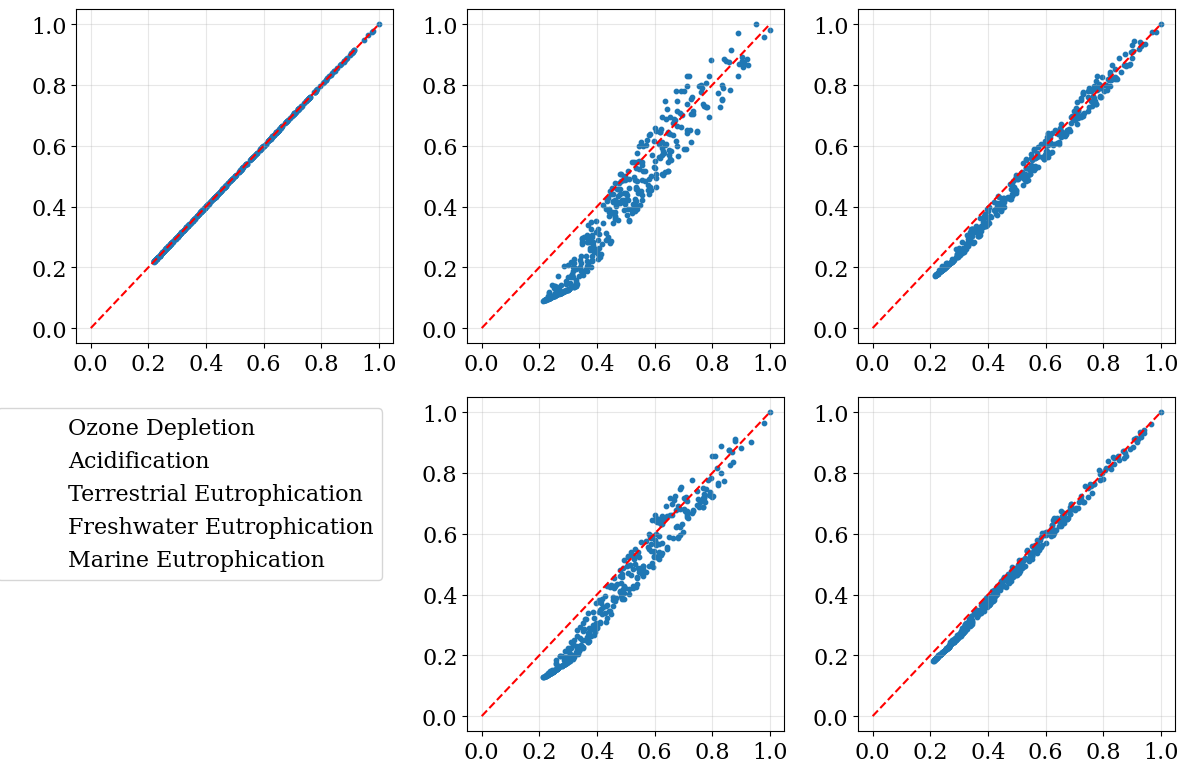

In [142]:
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=False)
fig, ax = plt.subplots(2,3, figsize=(12.5,8), sharex='col', sharey='row')
# ax = ax.flatten()

ax[0,0].scatter(normalize(obj1), normalize(obj2), s=10, label = 'Ozone Depletion')
# ax[0,0].set_title('Ozone Depletion')
ax[0,1].scatter(normalize(obj3), normalize(obj4), s=10, label = 'Acidification')
# ax[0,1].set_title('Acidification')
ax[0,2].scatter(normalize(obj5), normalize(obj6), s=10, label = 'Terrestrial Eutrophication')
# ax[0,2].set_title('Terrestrial Eutrophication')
ax[1, 0].axis('off')
ax[1,1].scatter(normalize(obj7), normalize(obj8), s=10, label = 'Freshwater Eutrophication')
# ax[1,1].set_title('Freshwater Eutrophication')
ax[1,2].scatter(normalize(obj9), normalize(obj10), s=10, label = 'Marine Eutrophication')
# ax[1,2].set_title('Marine Eutrophication')



ax[1,0].scatter(normalize(obj1), normalize(obj2), s=10, label = 'Ozone Depletion', alpha = 0)
ax[1,0].scatter(normalize(obj3), normalize(obj4), s=10, label = 'Acidification', alpha = 0)
ax[1,0].scatter(normalize(obj5), normalize(obj6), s=10, label = 'Terrestrial Eutrophication', alpha = 0)
ax[1,0].scatter(normalize(obj7), normalize(obj8), s=10, label = 'Freshwater Eutrophication', alpha = 0)
ax[1,0].scatter(normalize(obj9), normalize(obj10), s=10, label = 'Marine Eutrophication', alpha = 0)
ax[1,0].legend()

objs = ['Ozone Depletion', 'Acidification', 'Terrestrial Eutrophication', 'Freshwater Eutrophication', 'Marine Eutrophication']
# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
for i in [(0,0), (0,1), (0,2), (1,1), (1,2)]:
    # ax[i].legend()
    ax[i].xaxis.set_tick_params(labelbottom = 'False')
    ax[i].yaxis.set_tick_params(labelleft = 'False')
    
    # plt.title(f'Trade-off between objectives')
    ax[i].plot(x_1, x_1, linestyle = '--', color = 'red')
    # ax[i].set_title(objs[i])
    # ax[i].axis('off')
    ax[i].grid(zorder = 0, alpha = 0.3)
    # ax[i].set_xlabel("Global Warming")
# plt.legend()
# plt.grid(alpha=0.3)
plt.tight_layout()
plt.rcdefaults()

In [97]:
solution_moo.program.display_latex()

$$\min_{x}\left[\begin{matrix}0\\0\\0\\0\\0\\0\\0\\1.302e+03\\1.55e+03\\567.0\\990.0\end{matrix}\right]^T\left[\begin{matrix}x_{0}\\x_{1}\\x_{2}\\x_{3}\\x_{4}\\x_{5}\\x_{6}\\x_{7}\\x_{8}\\x_{9}\\x_{10}\end{matrix}\right] + \left[\begin{matrix}\theta_{0}\\\theta_{1}\\\theta_{2}\\\theta_{3}\\\theta_{4}\\\theta_{5}\\\theta_{6}\\\theta_{7}\\\theta_{8}\end{matrix}\right]^{T}\left[\begin{matrix}0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 2.121e+05 & 0.01062 & 1.664e+03 & 3.719e+03 & 120.5 & 854.2\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 7.2e+05 & 0.01594 & 6.552e+03 & 1.015e+04 & 553.8 & 903.1\\0 & 0 & 0 & 2.849e+05 & 0.006309 & 928.5 & 2.991e+03 & 118.1 & 298.4\end{matrix}\right]\left[\begin{matrix}x_{0}\\x_{1}\\x_{2}\\x_{3}\\x_{4}\\x_{5}\\x_{6}\\x_{7}\\x_{8}\\x_{9}\\x_{10}\

$$\min_{x}\left[\begin{matrix}0\\0\\0\\0\\0\\0\\0\\0\\0\\0\\0\end{matrix}\right]^T\left[\begin{matrix}x_{0}\\x_{1}\\x_{2}\\x_{3}\\x_{4}\\x_{5}\\x_{6}\\x_{7}\\x_{8}\\x_{9}\\x_{10}\end{matrix}\right] + \left[\begin{matrix}\theta_{0}\\\theta_{1}\\\theta_{2}\\\theta_{3}\\\theta_{4}\\\theta_{5}\\\theta_{6}\\\theta_{7}\\\theta_{8}\end{matrix}\right]^{T}\left[\begin{matrix}0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 2.121e+05 & 0.01062 & 1.664e+03 & 3.719e+03 & 120.5 & 854.2\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 7.2e+05 & 0.01594 & 6.552e+03 & 1.015e+04 & 553.8 & 903.1\\0 & 0 & 0 & 2.849e+05 & 0.006309 & 928.5 & 2.991e+03 & 118.1 & 298.4\end{matrix}\right]\left[\begin{matrix}x_{0}\\x_{1}\\x_{2}\\x_{3}\\x_{4}\\x_{5}\\x_{6}\\x_{7}\\x_{8}\\x_{9}\\x_{10}\end{matrix}\right]$$
$$\left[\begin{matrix}1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0\\-1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & -1.0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.0\end{matrix}\right]\left[\begin{matrix}x_{0}\\x_{1}\\x_{2}\\x_{3}\\x_{4}\\x_{5}\\x_{6}\\x_{7}\\x_{8}\\x_{9}\\x_{10}\end{matrix}\right]\leq\left[\begin{matrix}100.0\\-35.0\\0\\500.0\\100.0\\100.0\\50.0\\50.0\\100.0\\0\\0\\0\\0\\0\\0\\0\\0\\0\\0\\0\\0\\0\end{matrix}\right]+\left[\begin{matrix}0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\-80.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 100.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 100.0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{matrix}\right]\left[\begin{matrix}\theta_{0}\\\theta_{1}\\\theta_{2}\\\theta_{3}\\\theta_{4}\\\theta_{5}\\\theta_{6}\\\theta_{7}\\\theta_{8}\end{matrix}\right]$$
$$\left[\begin{matrix}1.0 & 0 & 0 & 0 & 0 & 0 & 1.0 & -1.0 & 0 & 0 & 0\\0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0.3537 & 0 & 0\\0 & 0 & -1.0 & 0 & 0 & 0 & -1.0 & 0.89 & -1.0 & 0.75 & 0.85\\0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & -3.184 & 0 & 0\\0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & -1.0 & 0\\0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & -1.0\end{matrix}\right]\left[\begin{matrix}x_{0}\\x_{1}\\x_{2}\\x_{3}\\x_{4}\\x_{5}\\x_{6}\\x_{7}\\x_{8}\\x_{9}\\x_{10}\end{matrix}\right]=\left[\begin{matrix}0\\0\\0\\0\\0\\0\end{matrix}\right]+\left[\begin{matrix}0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{matrix}\right]\left[\begin{matrix}\theta_{0}\\\theta_{1}\\\theta_{2}\\\theta_{3}\\\theta_{4}\\\theta_{5}\\\theta_{6}\\\theta_{7}\\\theta_{8}\end{matrix}\right]$$
$$\left[\begin{matrix}1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.0\\-1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & -1.0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & -1.0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & -1.0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & -1.0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1.0\end{matrix}\right]\left[\begin{matrix}\theta_{0}\\\theta_{1}\\\theta_{2}\\\theta_{3}\\\theta_{4}\\\theta_{5}\\\theta_{6}\\\theta_{7}\\\theta_{8}\end{matrix}\right]\leq\left[\begin{matrix}1.0\\1.0\\1.0\\1.0\\1.0\\1.0\\1.0\\1.0\\1.0\\0\\0\\0\\0\\0\\0\\0\\0\\0\end{matrix}\right]$$